In [59]:
import numpy as np
import pickle as pkl
import pandas as pd
import glob
import random
from Modules.rnn_utils.utilities import MinMax
from Modules.model_COMP_5430 import RNN
import matplotlib.pyplot as plt

ImportError: cannot import name 'Normalize' from 'Modules.rnn_utils.utilities' (c:\Users\achia\OneDrive\Desktop\College Folder\Senior Year\Fall 2023\Deep Learning\Project\Code\github\Stock_Forecasting_DL\Modules\rnn_utils\utilities.py)

## Retrieve Data

In [ ]:
# Retrive 10 random data files
files = glob.glob("../../archive/*.csv")
random.shuffle(files)
files = files[:10]

# files

## Preprocess

In [ ]:
def train_test_split(df, split=0.95):
    # if split=0.95, splits data into 95% training, 5% test
    max_index = round((len(df) - 1) * split)

    # adjusted close price [2 days ago, 1 day ago]
    train_inputs = [[df[i-2], df[i-1]] for i in range(2, max_index)]
    # target is the next day for a given input above
    train_targets = [i for i in df[2 : max_index]]

    assert len(train_inputs) == len(train_targets)

    test_inputs = [[df[i-2], df[i-1]] for i in range(max_index + 2, len(df))]
    test_targets = [i for i in df[max_index + 2:]]

    assert len(test_inputs) == len(test_targets)

    return np.array(train_inputs), np.array(train_targets), np.array(test_inputs), np.array(test_targets)

def to_3d(data):
    # reshape data to [inputs, timesteps, features]
    train = data.reshape(data.shape[0], data.shape[1], 1)
    return train


In [ ]:
def process_all_data(files):
    preprocessed_file_data = dict()
    # Retrieve + Clean data
    for file in files:
        df = pd.read_csv(file)
        df = df[['Close']]

        df_np = df.to_numpy()

        # Normalize data between 0 and 1
        scaler = Normalize(df_np)
        normalized = scaler.normalize_data(df_np)

        # Split data into 95% train, 5% test
        train_input, train_target, test_input, test_target = train_test_split(normalized, 0.95)

        # returns 3d array in format [inputs, timesteps, features]
        train_input_3d = to_3d(train_input)
        test_input_3d = to_3d(test_input)

        # record in dictionary
        preprocessed_file_data[file] = [train_input_3d, train_target, test_input_3d, test_target]

    # Return data ready to train
    return preprocessed_file_data, scaler

In [ ]:
preprocessed_data, scaler = process_all_data(files)

## Store Preprocessed Data in a pickle file

In [ ]:
ppData_scaler = [preprocessed_data, scaler]
with open('ppData_scaler_10_files.pkl', 'wb') as file:
    pkl.dump(ppData_scaler, file)

## Initialize Model

In [ ]:
model = RNN(1, 30, 1, 0.0001)

## Train Model

In [ ]:
# For each file in preprocessed data
i = 0
for key in preprocessed_data:
    print("File:",str(key))
    # Unpack dictionary into train, test variables
    train_test_list = preprocessed_data[key]
    train_input_3d, train_target, test_input_3d, test_target = train_test_list

    train_outputs = model.train(train_input_3d, train_target)
    test_outputs = model.test(test_input_3d)
    i += 1
    if i % 20 == 0 and i != 0:
        print(f" Trained {i} files so far...")

File: ../../archive\PM.csv
Epoch #0
Epoch #3423
Epoch #3423
Epoch #3423
Epoch #3423
Epoch #3423
Epoch #3423
Epoch #3423
Epoch #3423
Epoch #3423
File: ../../archive\CZR.csv
Epoch #0
Epoch #1864
Epoch #1864
Epoch #1864
Epoch #1864
Epoch #1864
Epoch #1864
Epoch #1864
Epoch #1864
Epoch #1864
File: ../../archive\PKI.csv
Epoch #0
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
File: ../../archive\SCHW.csv
Epoch #0
Epoch #8330
Epoch #8330
Epoch #8330
Epoch #8330
Epoch #8330
Epoch #8330
Epoch #8330
Epoch #8330
Epoch #8330
File: ../../archive\CLX.csv
Epoch #0
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
Epoch #11831
File: ../../archive\ADP.csv
Epoch #0
Epoch #10134
Epoch #10134
Epoch #10134
Epoch #10134
Epoch #10134
Epoch #10134
Epoch #10134
Epoch #10134
Epoch #10134
File: ../../archive\NWS.csv
Epoch #0
Epoch #2165
Epoch #2165
Epoch #2165
Epoch #2165
Epoch #2165
Epoch 

## DeNormalize For Output

In [ ]:
train_outputs = scaler.denormalize_data(train_outputs)
train_targets = scaler.denormalize_data(train_target)
test_outputs = scaler.denormalize_data(test_outputs)
test_targets = scaler.denormalize_data(test_target)

TypeError: 'numpy.float64' object is not iterable

In [ ]:
# Put RMSE Here
rmse = np.sqrt(np.mean((test_outputs - test_targets) ** 2))
print("RMSE:", rmse)

RMSE: 35889.32591148874


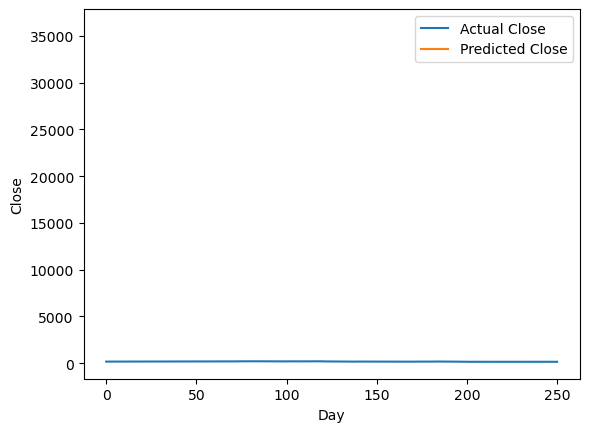

In [ ]:
plt.plot(test_targets, label='Actual Close')
plt.plot(test_outputs, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
def plot_model_predictions(test, preds):
    plot_test = pd.DataFrame(data=test, index=range(preds.size), columns=['Close'])
    plot_test['Day'] = plot_test.index
    plot_test = plot_test[:int(np.ceil(len(plot_test) * 0.9))]
    plot_pred = pd.DataFrame(data=preds, index=range(test.size), columns=['Predictions'])
    plot_pred['Day'] = plot_pred.index
    plot_pred = plot_pred[int(np.ceil(len(plot_pred) * 0.9)):]

    # fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    # axes[2][1].set_visible(False)
    
    plt.suptitle('Closing Price Predictions', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 15)

    # plt.facecolor('black')
    plt.plot(plot_test['Day'], plot_test['Close'], color = '#6522F5', label = 'Train')
    plt.plot(plot_pred['Day'], plot_pred['Predictions'], color = '#EB8791', label = 'Predictions')
    # plt.set_title('Meta', fontsize = 30)
    plt.xlabel('Time', fontsize = 10)
    plt.ylabel('Closing Price', fontsize = 10)
    # plt.xaxis.set_tick_params(labelsize = 18)
    # plt.yaxis.set_tick_params(labelsize = 18)
    plt.legend(loc = 'upper left', fontsize = 10)
    
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
plot_model_predictions(test_targets, test_outputs)

ValueError: Shape of passed values is (251, 1), indices imply (1, 1)